## Importación de Librerías

In [1]:
import pathlib
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import r2_score
import pandas as pd
import keras
from keras import backend as K
import os
import PIL
import PIL.Image
print(tf.__version__)

2.10.0


## Muestra Aleatoria de 300 Imagenes
Al principio cuando se realizó un primer intento para Data Argumentation, utilizamos la totalidad de las imagenes. Surgía un error en ese entonces donde por temás de tranasformación ciertas imagenes no eran tenidas en cuenta en la ejecución de las funciones de transformación y por lo tanto el error marcaba un error. Para esto, decidimos buscar algunas guias en linea que nos indicaran el motivo del error, en donde precisamente en los códigos subuidos por varios usuarios de Kaggle relacionados a esta base notamos que muchos tomaban de manera aleatoria un numero especifico de imagenes.

El código que se ve a continuación permite la selección aleatorio de dichas imagenes. Como muestra de respeto al trabajo del ususario de Kaggle, dejamos el siguiente [link](https://www.kaggle.com/code/encode0/mushrooms-classification-with-tensorflow) donde se puede ver el diseño de este código.

Este proceso se puede considerar como parte especial del pre-procesameinto debido a que al utilizar un número especifico de imagenes para cada clasificación aseguramos evitar usar metodos de aumento de data con el obejtivo de tener igualdad en el número de imágenes por clasificación de hongo. Esta tarea de aumento servirá para dar más variedad en las imagenes más adelante que permitan tener una mayor variación en las imagenes a procesar dentro del modelo.

In [2]:
## Direcciones donde se ubican las imagenes localmente y la nueva ubicación de las imagenes aleatorias encontradas
original_dir = pathlib.Path('H:\Mi unidad\Maestría\Clases\8. Deep Learning\Proyecto Final\Talleres_DL_UELBosque\Imagenes\Mushrooms')
new_base_dir = pathlib.Path('H:\Mi unidad\Maestría\Clases\8. Deep Learning\Proyecto Final\Talleres_DL_UELBosque\Muestra Inicial Aleatoria')
class_names = os.listdir('H:\Mi unidad\Maestría\Clases\8. Deep Learning\Proyecto Final\Talleres_DL_UELBosque\Imagenes\Mushrooms')

## Loop para la selección aleatoria de imagenes y copia en la nueva ubicación.
for mushroom in class_names:
    dir = new_base_dir / mushroom
    os.makedirs(dir, exist_ok=True)
    fnames = random.sample(os.listdir(original_dir / mushroom), k=300)
    for fname in fnames:
        shutil.copyfile(src=original_dir / mushroom / fname,
                       dst=dir / fname)

NameError: name 'shutil' is not defined

## Generación de Sets de Entrenamiento y Validación

Con la data aleatorizada, pasamos al proceso de generación de los datos de entrenamiento, validación y prueba del modelo. Utilizamos la relación 70-30.

In [40]:
batch = 10
height = 100
width = 100
dir='H:\Mi unidad\Maestría\Clases\8. Deep Learning\Proyecto Final\Talleres_DL_UELBosque\Muestra Inicial Aleatoria'

train_set = tf.keras.utils.image_dataset_from_directory(dir,
                                                        validation_split=0.2,
                                                        subset="training",
                                                        seed=22081995,
                                                        image_size=(height, width),
                                                        batch_size=batch)
val_set = tf.keras.utils.image_dataset_from_directory(dir,
                                                        validation_split=0.2,
                                                        subset="validation",
                                                        seed=22081995,
                                                        image_size=(height, width),
                                                        batch_size=batch)

Found 2700 files belonging to 9 classes.
Using 2160 files for training.
Found 2700 files belonging to 9 classes.
Using 540 files for validation.


Verificamos la clasificación de los labels.

In [41]:
class_names = train_set.class_names
print(class_names)

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


Y al mísmo tiempo revisamos la estructura del tensor de entrenamiento del modelo.

In [42]:
train_set

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Ahora una muestra de las imagenes seleccionadas en el set de entrenamiento.

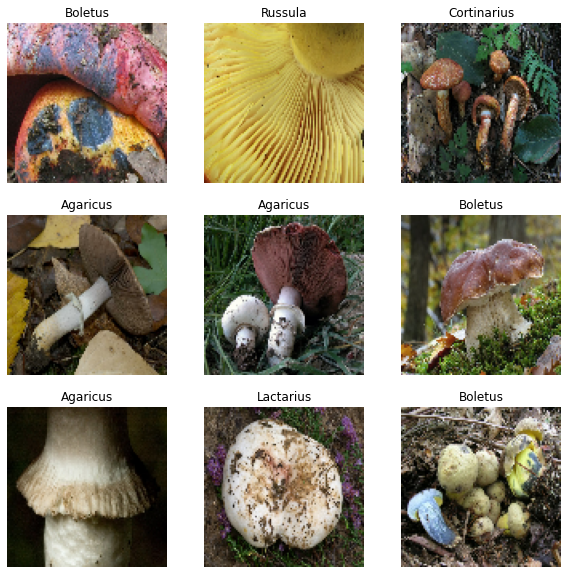

In [43]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [44]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 100, 100, 3)
(10,)


## Data Augmentation

Ya teniendo particionada la data, pasamos al proceso de aumento en donde haremos modificaciones a ciertas imagenes para lograr equivalencia en las cantidades de cada una de ellas en las diferentes clasificaciones de hongos (subcarpetas). Primero se realiza una normalización de los datos, seguido de un proceso de rotación de izquierda a derecha, de arriba a abajo y rotación de 90°.

In [45]:
def normalize_img(image,label ):
  return tf.cast(image, tf.float32) / 255., tf.one_hot(label,depth=10)


def data_load(data_ds,augmented=normalize_img,shuffle_=True ,batch_=5):
    data_ds = data_ds.map(
        augmented, num_parallel_calls=tf.data.AUTOTUNE)
    data_ds = data_ds.cache()
    if shuffle_:
        data_ds = data_ds.shuffle(len(data_ds))
    data_ds = data_ds.batch(batch_)
    data_ds = data_ds.prefetch(tf.data.AUTOTUNE)
    return data_ds

data_train = data_load(train_set)
data_test = data_load(val_set,shuffle_=False)

(5, 10, 100, 100, 3) tf.Tensor(
[[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 

TypeError: Invalid shape (10, 100, 100, 3) for image data

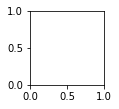

In [46]:
plt.figure(figsize=(3, 3))
i=0
for ds,lb in data_train.take(4):
    print(ds.shape,lb)
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(np.squeeze(ds[0].numpy()))
    index = tf.argmax(lb, axis=1)
    plt.title('{}'.format(index[0].numpy()))
    plt.axis("off")
    i+=1

In [47]:
def augment_data(images, labels):
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.rot90(images)
    return images, labels

In [48]:
data_train = data_load(train_set,augmented=augment_data)
data_test = data_load(val_set,augmented=augment_data,shuffle_=False)

(5, 10, 100, 100, 3) tf.Tensor(
[[1 0 2 6 2 0 1 7 0 8]
 [3 2 7 1 0 8 2 8 6 0]
 [1 7 0 2 5 3 1 0 0 7]
 [8 1 2 2 8 7 4 4 4 8]
 [8 5 1 8 5 2 6 4 0 6]], shape=(5, 10), dtype=int32)


TypeError: Invalid shape (10, 100, 100, 3) for image data

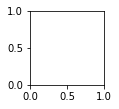

In [49]:
plt.figure(figsize=(3, 3))
i=0
for ds,lb in data_train.take(4):
    print(ds.shape,lb)
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(np.squeeze(ds[0].numpy()))
    plt.title('{}'.format(lb[0].numpy()))
    plt.axis("off")
    i+=1